In [3]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 64.3 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import mne

In [7]:
# load in EEG file
eeg_fp = '/content/2025-02-26_14-46-27.txt'
trial_data = np.genfromtxt(fname=eeg_fp, skip_header=1, delimiter=",")
trial_data

array([[-11479.31951038,  20343.79784391,  17884.50245672, ...,
         21204.02708102,  27682.92608058,   1629.08454288],
       [-11473.08337368,  20354.19140508,  17888.97280562, ...,
         21207.51395315,  27688.75988588,   1634.09133364],
       [-11476.32437662,  20340.55684096,  17883.72014567, ...,
         21203.15536298,  27687.95522308,   1633.19726386],
       ...,
       [-10845.53579635,  20423.97355127,  17891.96793937, ...,
         21057.77961704,  27660.19435646,   1875.49017376],
       [-10849.7826278 ,  20409.82489703,  17889.75511667, ...,
         21051.23055592,  27656.30515293,   1875.33371154],
       [-10851.41430514,  20408.5508476 ,  17890.13509633, ...,
         21051.40936988,  27655.16521396,   1875.28900806]])

In [8]:
# Declares channel names and types of each set of data
sfreq = 250  # sample rate in Hz
ch_names = ['Channel {}'.format(i) for i in range(trial_data.shape[1])]
ch_types = ['eeg' for i in range(trial_data.shape[1])]

In [9]:
# Create info structures and RawArray objects for each set of data
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(trial_data.T, info)

Creating RawArray with float64 data, n_channels=8, n_times=12000
    Range : 0 ... 11999 =      0.000 ...    47.996 secs
Ready.


<Info | 7 non-empty values
 bads: []
 ch_names: Channel 0, Channel 1, Channel 2, Channel 3, Channel 4, Channel ...
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>
[[-11479.31951038 -11473.08337368 -11476.32437662 ... -10845.53579635
  -10849.7826278  -10851.41430514]
 [ 20343.79784391  20354.19140508  20340.55684096 ...  20423.97355127
   20409.82489703  20408.5508476 ]
 [ 17884.50245672  17888.97280562  17883.72014567 ...  17891.96793937
   17889.75511667  17890.13509633]
 ...
 [ 21204.02708102  21207.51395315  21203.15536298 ...  21057.77961704
   21051.23055592  21051.40936988]
 [ 27682.92608058  27688.75988588  27687.95522308 ...  27660.19435646
   27656.30515293  27655.16521396]
 [  1629.08454288   1634.09133364   1633.19726386 ...   1875.49017376
    1875.33371154   1875.28900806]]
Using matplotlib as 2D backend.


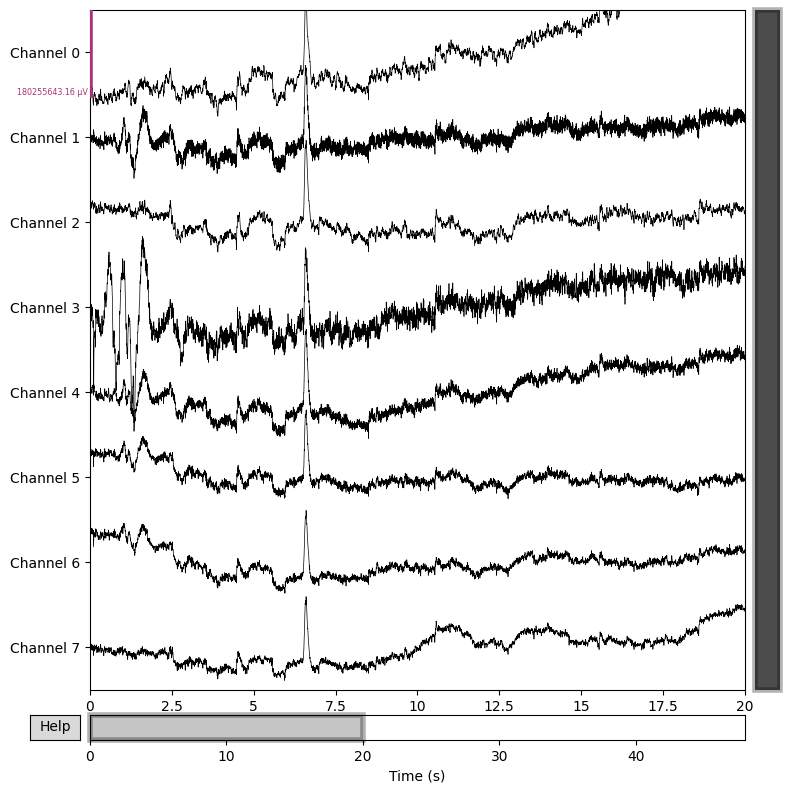

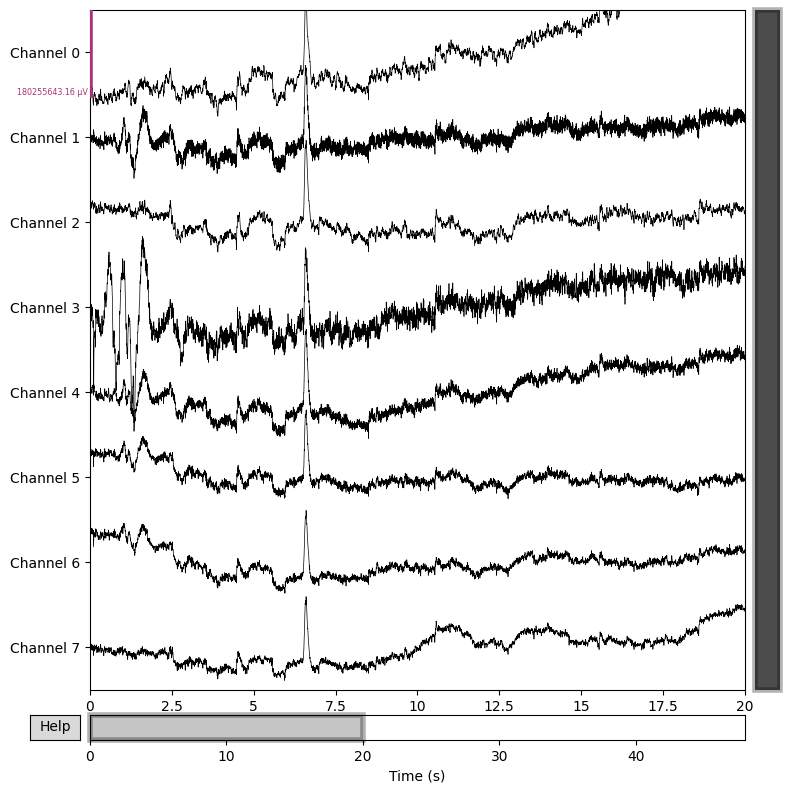

In [10]:
# Now you can work with the MNE Raw object
print(raw.info)
print(raw.get_data())

# Plot the specified interval
raw.plot(duration=20, scalings='auto')

In [13]:
from scipy.signal import butter, filtfilt, iirnotch

In [23]:
import numpy as np
import mne
from scipy.signal import butter, filtfilt, iirnotch

#trca
class TRCA:
    def __init__(self):
        self.filters = None

    def fit_transform(self, eeg_data):

        if eeg_data.ndim == 2: #reshapes
            eeg_data = eeg_data[np.newaxis, :, :]

        n_trials, n_channels, n_samples = eeg_data.shape
        S = np.zeros((n_channels, n_channels))

        #covariance matrix
        for trial in range(n_trials):
            for i in range(n_samples - 1):
                S += np.dot(eeg_data[trial, :, i][:, None], eeg_data[trial, :, i + 1][None, :])

        # Solve generalized eigenvalue problem
        eigvals, eigvecs = np.linalg.eig(S)

        # Sort eigenvectors by eigenvalues
        sorted_indices = np.argsort(eigvals)[::-1]
        self.filters = eigvecs[:, sorted_indices]

        #eeg data on trca components
        transformed_data = np.dot(self.filters.T, eeg_data.mean(axis=0))  # Averaging across trials

        return transformed_data

#bandpass filter
def bandpass_filter(data, lowcut=4, highcut=100, fs=256, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data, axis=-1)  #last axis

#notch filter
def notch_filter(data, freq=60, fs=256, quality_factor=30):
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    padlen = min(data.shape[-1] - 1, 3 * max(len(a), len(b)))
    if padlen < 0:
        padlen = 0
    return filtfilt(b, a, data, axis=-1, padlen=padlen)


raw_filtered = raw.copy().filter(4, 100, fir_design='firwin')
raw_filtered._data = notch_filter(raw_filtered.get_data())

#trca feature extraction
trca = TRCA()
trca_features = trca.fit_transform(raw_filtered.get_data())

#correlation
trca_features_transposed = trca_features.T
stimulus_pattern = np.random.rand(trca_features_transposed.shape[1])  # Matching shape

correlation_coefficients = np.array([
    np.corrcoef(trca_features_transposed[i, :], stimulus_pattern)[0, 1]
    for i in range(trca_features_transposed.shape[0])
])

#vectors
direction_vectors = np.sign(correlation_coefficients)  # Gaze tracking
magnitude_vectors = np.abs(correlation_coefficients)  # Focus intensity

# --------------- Store Processed Data -----------------
processed_data = {
    "filtered_eeg": raw_filtered.get_data(),
    "trca_features": trca_features,
    "direction_vectors": direction_vectors,
    "magnitude_vectors": magnitude_vectors,
}



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 413 samples (1.652 s)



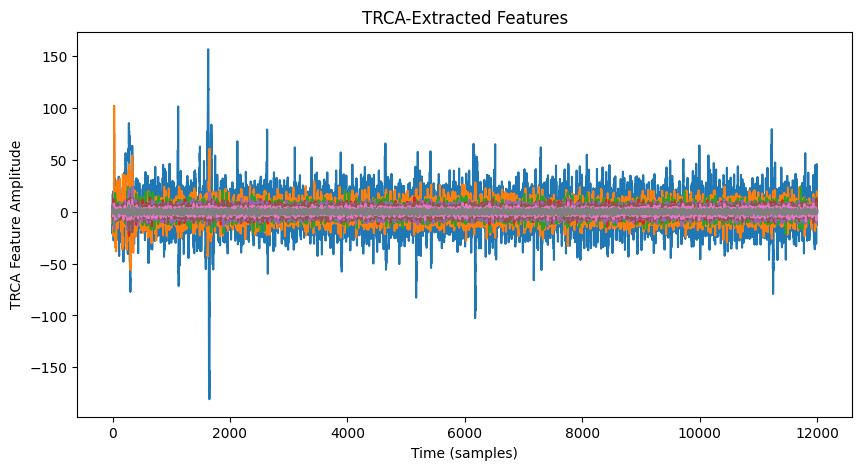

In [24]:
#plot trca features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(trca_features.T)  # TRCA features are in (components, samples)
plt.xlabel("Time (samples)")
plt.ylabel("TRCA Feature Amplitude")
plt.title("TRCA-Extracted Features")
plt.show()
